In [47]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

# Dataset: VHM Historical Data

In [48]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/1 - VHM Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df

,Price
Date,
2019-03-01,68421.0
2019-03-04,70075.0
2019-03-05,68421.0
2019-03-06,69022.0
2019-03-07,69173.0
...,...
2024-05-27,39800.0
2024-05-28,39950.0
2024-05-29,39450.0


In [49]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

## Ratio 7:3

In [50]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [51]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [52]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [53]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [54]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [55]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 4s 77ms/step - loss: 0.2026
Epoch 2/100
13/13 [==============================] - 1s 80ms/step - loss: 0.0169
Epoch 3/100
13/13 [==============================] - 1s 58ms/step - loss: 0.0118
Epoch 4/100
13/13 [==============================] - 1s 45ms/step - loss: 0.0073
Epoch 5/100
13/13 [==============================] - 1s 48ms/step - loss: 0.0058
Epoch 6/100
13/13 [==============================] - 1s 45ms/step - loss: 0.0049
Epoch 7/100
13/13 [==============================] - 1s 47ms/step - loss: 0.0042
Epoch 8/100
13/13 [==============================] - 1s 46ms/step - loss: 0.0036
Epoch 9/100
13/13 [==============================] - 1s 46ms/step - loss: 0.0031
Epoch 10/100
13/13 [==============================] - 1s 47ms/step - loss: 0.0026
Epoch 11/100
13/13 [==============================] - 1s 44ms/step - loss: 0.0022
Epoch 12/100
13/13 [==============================] - 1s 48ms/step - loss: 0.0019
Epoch 13/100
13/13 [=====

In [56]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

10/10 [==============================] - 1s 17ms/step


In [57]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [58]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1138.9680639563044
Testing MAPE: 1.8017624824383764
Testing MAE: 847.1990854308875


In [59]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

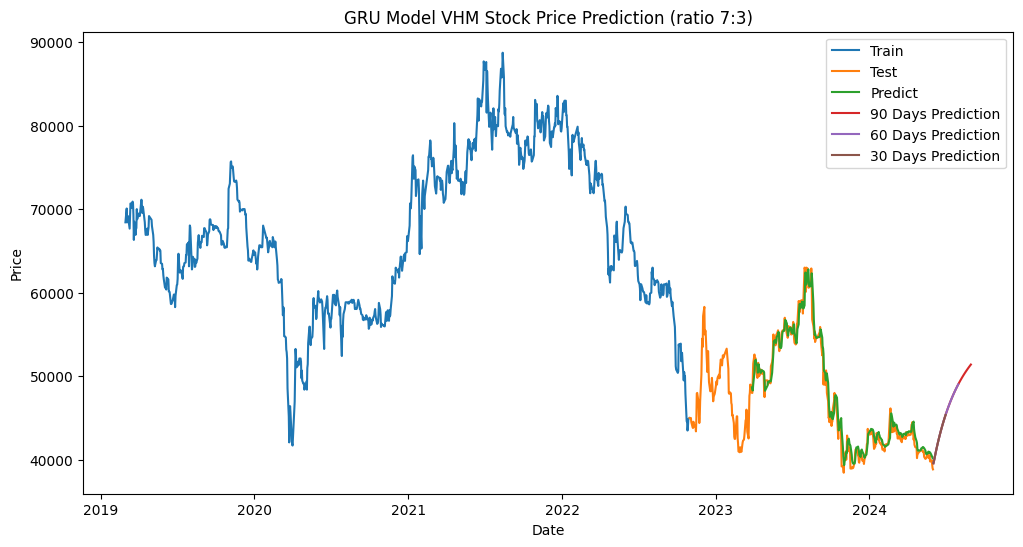

In [60]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('GRU Model VHM Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

## Ratio 8:2

In [61]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [62]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [63]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [64]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [65]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [66]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 3s 47ms/step - loss: 0.1268
Epoch 2/100
15/15 [==============================] - 1s 47ms/step - loss: 0.0163
Epoch 3/100
15/15 [==============================] - 1s 47ms/step - loss: 0.0092
Epoch 4/100
15/15 [==============================] - 1s 48ms/step - loss: 0.0068
Epoch 5/100
15/15 [==============================] - 1s 46ms/step - loss: 0.0049
Epoch 6/100
15/15 [==============================] - 1s 47ms/step - loss: 0.0034
Epoch 7/100
15/15 [==============================] - 1s 47ms/step - loss: 0.0023
Epoch 8/100
15/15 [==============================] - 1s 46ms/step - loss: 0.0016
Epoch 9/100
15/15 [==============================] - 1s 47ms/step - loss: 0.0013
Epoch 10/100
15/15 [==============================] - 1s 73ms/step - loss: 0.0012
Epoch 11/100
15/15 [==============================] - 1s 76ms/step - loss: 0.0011
Epoch 12/100
15/15 [==============================] - 1s 80ms/step - loss: 0.0011
Epoch 13/100
15/15 [=====

In [67]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

6/6 [==============================] - 0s 10ms/step


In [68]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [69]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 899.522954751396
Testing MAPE: 1.5849612318584239
Testing MAE: 664.4819155092592


In [70]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

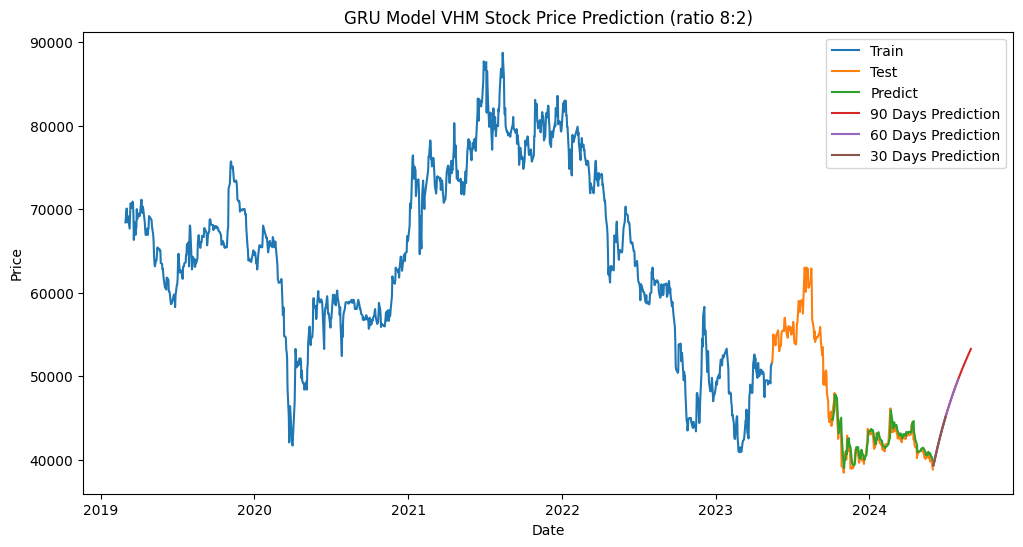

In [71]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('GRU Model VHM Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

## Ratio 9:1

In [72]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [73]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [74]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [75]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [76]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [77]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 3s 47ms/step - loss: 0.1009
Epoch 2/100
17/17 [==============================] - 1s 48ms/step - loss: 0.0148
Epoch 3/100
17/17 [==============================] - 1s 46ms/step - loss: 0.0084
Epoch 4/100
17/17 [==============================] - 1s 47ms/step - loss: 0.0054
Epoch 5/100
17/17 [==============================] - 1s 59ms/step - loss: 0.0034
Epoch 6/100
17/17 [==============================] - 1s 78ms/step - loss: 0.0021
Epoch 7/100
17/17 [==============================] - 1s 80ms/step - loss: 0.0015
Epoch 8/100
17/17 [==============================] - 1s 60ms/step - loss: 0.0013
Epoch 9/100
17/17 [==============================] - 1s 45ms/step - loss: 0.0013
Epoch 10/100
17/17 [==============================] - 1s 46ms/step - loss: 0.0013
Epoch 11/100
17/17 [==============================] - 1s 47ms/step - loss: 0.0013
Epoch 12/100
17/17 [==============================] - 1s 49ms/step - loss: 0.0012
Epoch 13/100
17/17 [=====

In [78]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

1/1 [==============================] - 0s 438ms/step


In [79]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [80]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 566.9545240470729
Testing MAPE: 0.9460318938449246
Testing MAE: 386.60442708333335


In [81]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

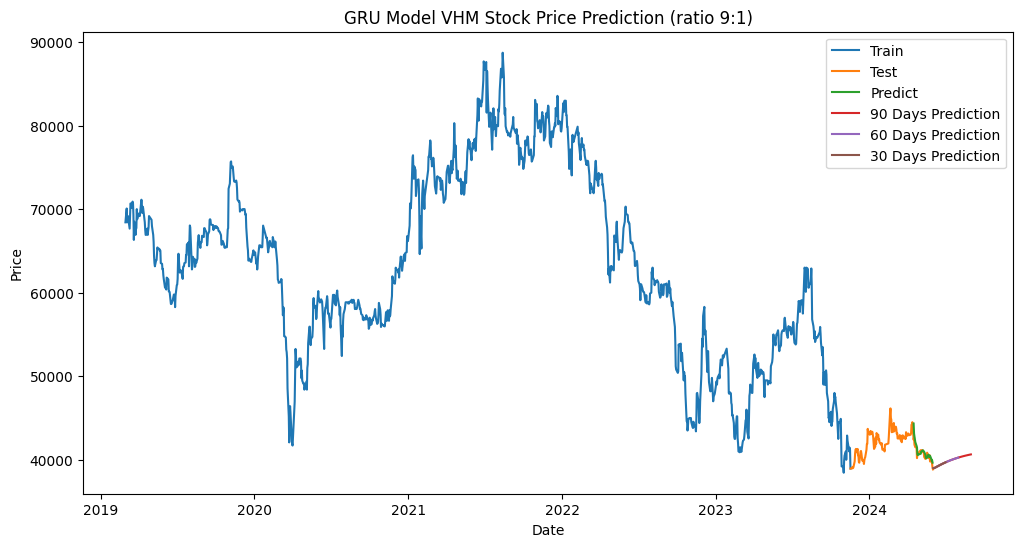

In [82]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('GRU Model VHM Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

# Dataset: NVL Historical Data

In [148]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/2 - NVL Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df

,Price
Date,
2019-03-01,32933.0
2019-03-04,33100.0
2019-03-05,32711.0
2019-03-06,31709.0
2019-03-07,31932.0
...,...
2024-05-27,14500.0
2024-05-28,14500.0
2024-05-29,14150.0


In [149]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

## Ratio 7:3

In [150]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [151]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [152]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [153]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [154]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [155]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 3s 48ms/step - loss: 0.2135
Epoch 2/100
13/13 [==============================] - 1s 49ms/step - loss: 0.0209
Epoch 3/100
13/13 [==============================] - 1s 48ms/step - loss: 0.0131
Epoch 4/100
13/13 [==============================] - 1s 48ms/step - loss: 0.0090
Epoch 5/100
13/13 [==============================] - 1s 49ms/step - loss: 0.0053
Epoch 6/100
13/13 [==============================] - 1s 69ms/step - loss: 0.0032
Epoch 7/100
13/13 [==============================] - 1s 80ms/step - loss: 0.0019
Epoch 8/100
13/13 [==============================] - 1s 79ms/step - loss: 9.7573e-04
Epoch 9/100
13/13 [==============================] - 1s 84ms/step - loss: 5.7595e-04
Epoch 10/100
13/13 [==============================] - 1s 56ms/step - loss: 4.2987e-04
Epoch 11/100
13/13 [==============================] - 1s 46ms/step - loss: 3.9121e-04
Epoch 12/100
13/13 [==============================] - 1s 48ms/step - loss: 3.8133e-04
Epoch

In [156]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

10/10 [==============================] - 1s 10ms/step


In [157]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [158]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 649.9559686752832
Testing MAPE: 3.0018966886632668
Testing MAE: 483.3981341990188


In [159]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

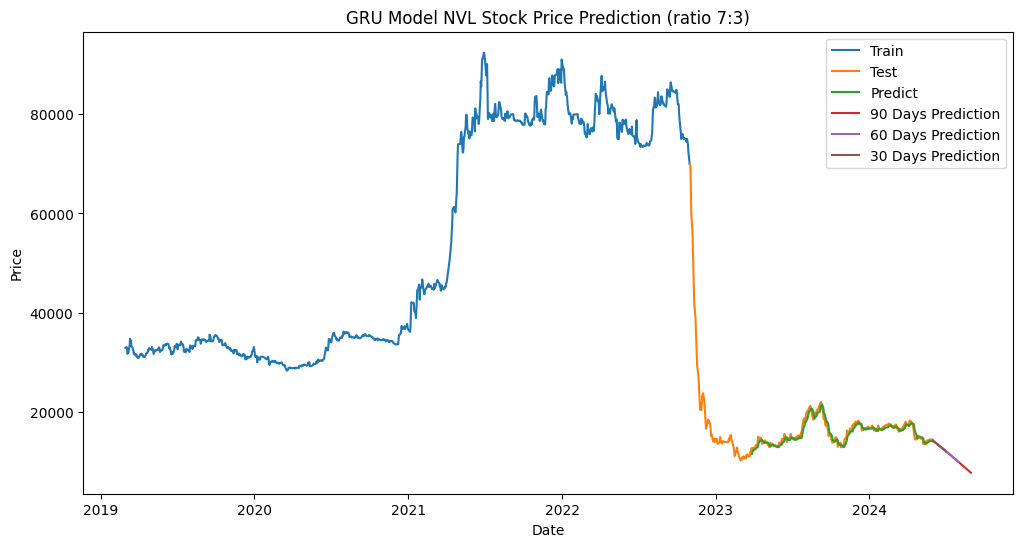

In [160]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('GRU Model NVL Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

## Ratio 8:2

In [161]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [162]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [163]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [164]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [165]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [166]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 4s 52ms/step - loss: 0.2675
Epoch 2/100
15/15 [==============================] - 1s 48ms/step - loss: 0.0349
Epoch 3/100
15/15 [==============================] - 1s 48ms/step - loss: 0.0194
Epoch 4/100
15/15 [==============================] - 1s 49ms/step - loss: 0.0114
Epoch 5/100
15/15 [==============================] - 1s 48ms/step - loss: 0.0058
Epoch 6/100
15/15 [==============================] - 1s 47ms/step - loss: 0.0026
Epoch 7/100
15/15 [==============================] - 1s 47ms/step - loss: 0.0012
Epoch 8/100
15/15 [==============================] - 1s 49ms/step - loss: 8.6463e-04
Epoch 9/100
15/15 [==============================] - 1s 47ms/step - loss: 8.2413e-04
Epoch 10/100
15/15 [==============================] - 1s 47ms/step - loss: 7.9084e-04
Epoch 11/100
15/15 [==============================] - 1s 47ms/step - loss: 7.5706e-04
Epoch 12/100
15/15 [==============================] - 1s 48ms/step - loss: 7.3164e-04
Epoch

In [167]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

6/6 [==============================] - 1s 19ms/step


In [168]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [169]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 602.6581957360742
Testing MAPE: 3.008449656878618
Testing MAE: 477.49071059992286


In [170]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

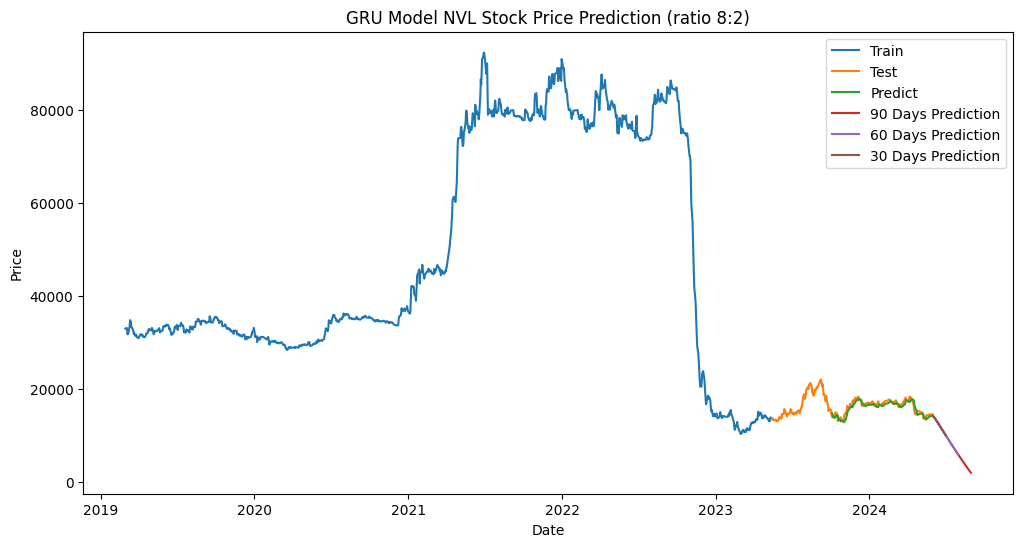

In [171]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('GRU Model NVL Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

## Ratio 9:1

In [172]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [173]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [174]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [175]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [176]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [177]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 3s 48ms/step - loss: 0.0731
Epoch 2/100
17/17 [==============================] - 1s 48ms/step - loss: 0.0144
Epoch 3/100
17/17 [==============================] - 1s 47ms/step - loss: 0.0050
Epoch 4/100
17/17 [==============================] - 1s 53ms/step - loss: 0.0014
Epoch 5/100
17/17 [==============================] - 1s 79ms/step - loss: 5.1976e-04
Epoch 6/100
17/17 [==============================] - 1s 80ms/step - loss: 4.5115e-04
Epoch 7/100
17/17 [==============================] - 1s 64ms/step - loss: 4.1509e-04
Epoch 8/100
17/17 [==============================] - 1s 47ms/step - loss: 3.9838e-04
Epoch 9/100
17/17 [==============================] - 1s 48ms/step - loss: 3.9018e-04
Epoch 10/100
17/17 [==============================] - 1s 46ms/step - loss: 3.7056e-04
Epoch 11/100
17/17 [==============================] - 1s 48ms/step - loss: 3.5999e-04
Epoch 12/100
17/17 [==============================] - 1s 48ms/step - loss: 3.47

In [178]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

1/1 [==============================] - 1s 707ms/step


In [179]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [180]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 509.1598880514927
Testing MAPE: 2.544831983645446
Testing MAE: 376.0486328124999


In [181]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

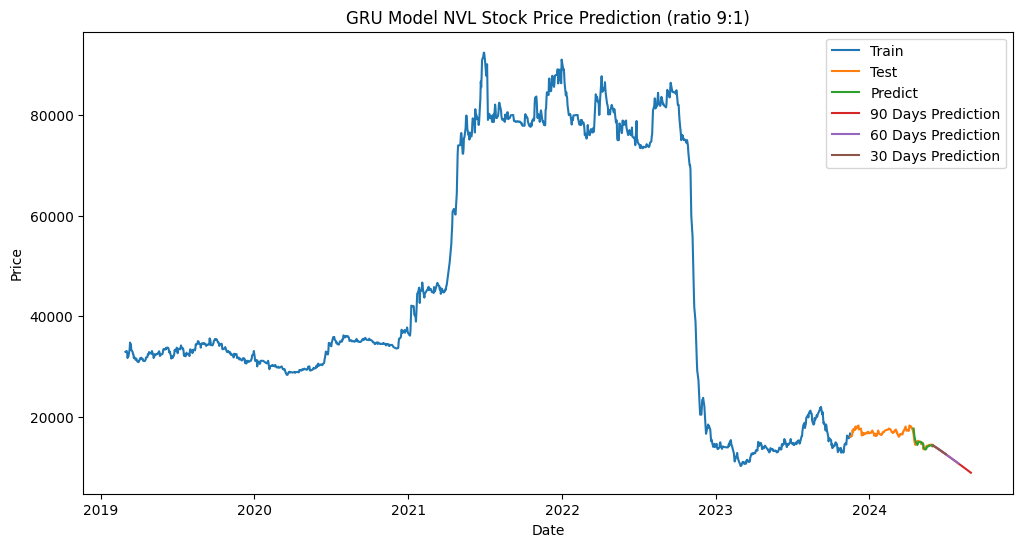

In [182]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('GRU Model NVL Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

# Dataset: NLG Historical Data

In [253]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/3 - NLG Historical Data.csv')
df = df.dropna()

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date')
df = df.sort_index()

temp_data = df.reset_index()

# Format column "Price", "Open", "High", "Low"
for col in ['Price', 'Open', 'High', 'Low']:
    df[col] = df[col].str.replace(',', '').astype(float)

df = df[['Price']]
df

,Price
Date,
2019-03-01,18706.8
2019-03-04,19127.2
2019-03-05,18917.0
2019-03-06,18846.9
2019-03-07,18706.8
...,...
2024-05-27,43900.0
2024-05-28,43701.0
2024-05-29,44400.0


In [254]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

## Ratio 7:3

In [255]:
# 4. Chia train test
train_size = round(0.7 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [256]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [257]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [258]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [259]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [260]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 4s 53ms/step - loss: 0.1185
Epoch 2/100
13/13 [==============================] - 1s 61ms/step - loss: 0.0228
Epoch 3/100
13/13 [==============================] - 1s 56ms/step - loss: 0.0137
Epoch 4/100
13/13 [==============================] - 1s 57ms/step - loss: 0.0075
Epoch 5/100
13/13 [==============================] - 1s 51ms/step - loss: 0.0030
Epoch 6/100
13/13 [==============================] - 1s 53ms/step - loss: 0.0013
Epoch 7/100
13/13 [==============================] - 1s 60ms/step - loss: 0.0011
Epoch 8/100
13/13 [==============================] - 1s 81ms/step - loss: 9.9384e-04
Epoch 9/100
13/13 [==============================] - 2s 117ms/step - loss: 9.4079e-04
Epoch 10/100
13/13 [==============================] - 1s 109ms/step - loss: 9.0075e-04
Epoch 11/100
13/13 [==============================] - 1s 106ms/step - loss: 8.7562e-04
Epoch 12/100
13/13 [==============================] - 1s 77ms/step - loss: 8.5141e-04
Ep

In [261]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

10/10 [==============================] - 1s 14ms/step


In [262]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [263]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1017.6958700046082
Testing MAPE: 2.095350436174809
Testing MAE: 754.0259505652731


In [264]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

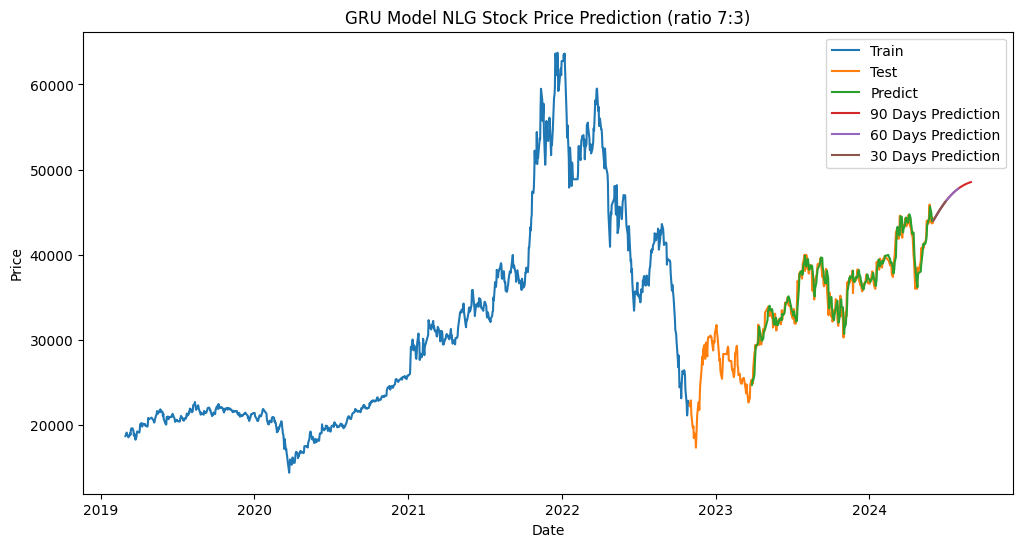

In [265]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('GRU Model NLG Stock Price Prediction (ratio 7:3)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

## Ratio 8:2

In [266]:
# 4. Chia train test
train_size = round(0.8 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [267]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [268]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [269]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [270]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [271]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 4s 92ms/step - loss: 0.0556
Epoch 2/100
15/15 [==============================] - 1s 92ms/step - loss: 0.0135
Epoch 3/100
15/15 [==============================] - 2s 105ms/step - loss: 0.0056
Epoch 4/100
15/15 [==============================] - 1s 64ms/step - loss: 0.0021
Epoch 5/100
15/15 [==============================] - 1s 62ms/step - loss: 0.0010
Epoch 6/100
15/15 [==============================] - 1s 63ms/step - loss: 8.5188e-04
Epoch 7/100
15/15 [==============================] - 1s 69ms/step - loss: 8.1456e-04
Epoch 8/100
15/15 [==============================] - 1s 66ms/step - loss: 7.8290e-04
Epoch 9/100
15/15 [==============================] - 1s 71ms/step - loss: 7.6104e-04
Epoch 10/100
15/15 [==============================] - 1s 68ms/step - loss: 7.4233e-04
Epoch 11/100
15/15 [==============================] - 1s 87ms/step - loss: 7.2900e-04
Epoch 12/100
15/15 [==============================] - 1s 73ms/step - loss: 7.2189e

In [272]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

6/6 [==============================] - 1s 17ms/step


In [273]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [274]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 970.8321694578157
Testing MAPE: 1.9082968947699956
Testing MAE: 720.3825954861111


In [275]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

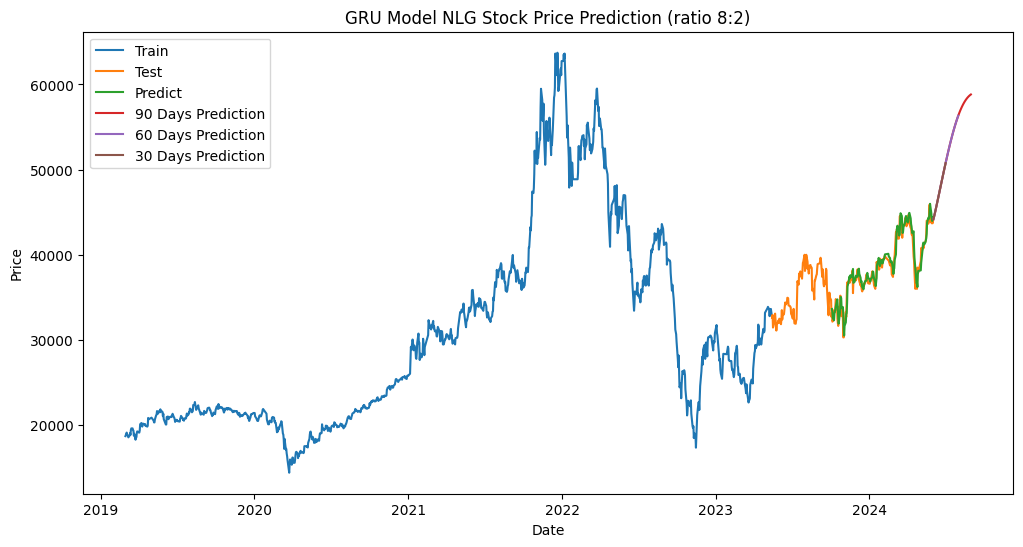

In [276]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('GRU Model NLG Stock Price Prediction (ratio 8:2)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

## Ratio 9:1

In [277]:
# 4. Chia train test
train_size = round(0.9 * len(df))
test_size = round(len(df) - train_size)

train_data = df[:train_size + 1]
test_data = df[train_size:]

In [278]:
# 5. Hàm Create Dataset
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [279]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [280]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [281]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [282]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 5s 64ms/step - loss: 0.0341
Epoch 2/100
17/17 [==============================] - 1s 56ms/step - loss: 0.0078
Epoch 3/100
17/17 [==============================] - 1s 58ms/step - loss: 0.0028
Epoch 4/100
17/17 [==============================] - 1s 70ms/step - loss: 0.0011
Epoch 5/100
17/17 [==============================] - 1s 85ms/step - loss: 7.5504e-04
Epoch 6/100
17/17 [==============================] - 2s 95ms/step - loss: 7.1969e-04
Epoch 7/100
17/17 [==============================] - 1s 83ms/step - loss: 6.9297e-04
Epoch 8/100
17/17 [==============================] - 1s 81ms/step - loss: 6.6907e-04
Epoch 9/100
17/17 [==============================] - 1s 54ms/step - loss: 6.5741e-04
Epoch 10/100
17/17 [==============================] - 1s 53ms/step - loss: 6.4426e-04
Epoch 11/100
17/17 [==============================] - 1s 52ms/step - loss: 6.2513e-04
Epoch 12/100
17/17 [==============================] - 1s 56ms/step - loss: 6.16

In [283]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

1/1 [==============================] - 1s 643ms/step


In [284]:
# 11. Chuẩn hóa dữ liệu y_pred, ytest
ytest=scaler.inverse_transform(ytest.reshape(-1,1))
y_pred=scaler.inverse_transform(y_pred)

In [285]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mape = mean_absolute_percentage_error(ytest, y_pred) * 100
test_mae = mean_absolute_error(ytest, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 1160.8604555761888
Testing MAPE: 2.21112543779887
Testing MAE: 898.4203125


In [286]:
# 13. Dự báo 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, future_days):
    x_input = data[-time_step:].reshape(1, -1)
    temp_input = x_input[0].tolist()
    lst_output = []
    i = 0
    while i < future_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
            i += 1
        else:
            x_input = np.array(temp_input).reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i += 1
    return lst_output

n_steps = 100

pred_30_days = predict_future(model, test_data, n_steps, 30)
pred_60_days = predict_future(model, test_data, n_steps, 60)
pred_90_days = predict_future(model, test_data, n_steps, 90)

pred_30_days = scaler.inverse_transform(np.array(pred_30_days).reshape(-1, 1))
pred_60_days = scaler.inverse_transform(np.array(pred_60_days).reshape(-1, 1))
pred_90_days = scaler.inverse_transform(np.array(pred_90_days).reshape(-1, 1))

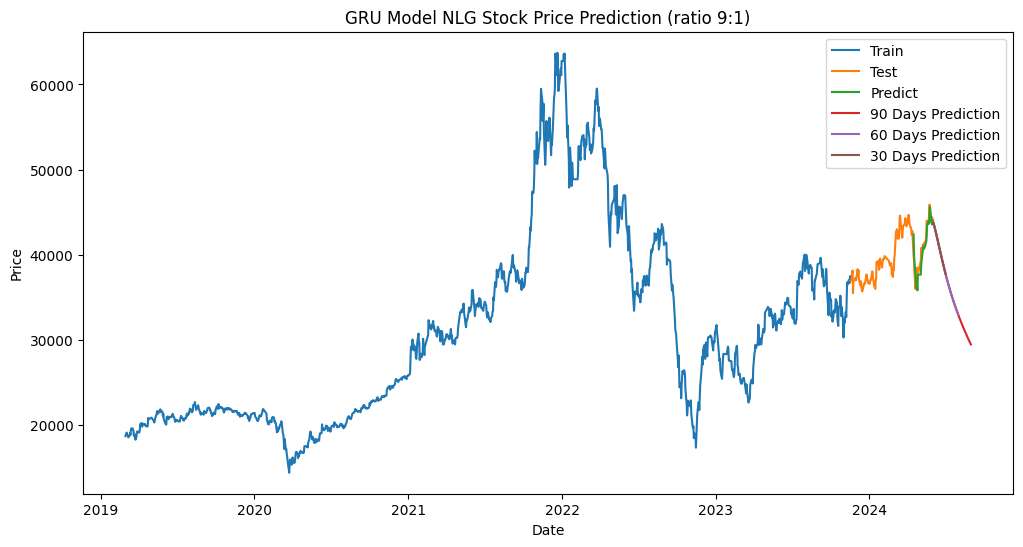

In [287]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(temp_data['Date'])

plt.plot(dates[:train_size+1], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')

last_date = dates.iloc[-1]

# Dự đoán cho 30 ngày tiếp theo
future_dates_30 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Dự đoán cho 60 ngày tiếp theo
future_dates_60 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60)

# Dự đoán cho 90 ngày tiếp theo
future_dates_90 = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90)

plt.plot(future_dates_90, np.concatenate((pred_30_days, pred_60_days[30:], pred_90_days[60:])), label='90 Days Prediction')
plt.plot(future_dates_60, np.concatenate((pred_30_days, pred_60_days[30:])), label='60 Days Prediction')
plt.plot(future_dates_30, pred_30_days, label='30 Days Prediction')
plt.title('GRU Model NLG Stock Price Prediction (ratio 9:1)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()